<a href="https://colab.research.google.com/github/sindhu213/Research-Papers/blob/master/src/Effective_Approaches_to_NMT_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import torch
import random
from torch import nn
from urllib.request import urlopen
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Preparing Data

In [2]:
link = "https://raw.githubusercontent.com/suvaansh/Machine-Translation-English-to-Hindi-/master/hin.txt"

with urlopen(link) as url:
  temp = url.read().decode('utf-8').split('\n')
  ds = [item.split('\t') for item in temp]

In [3]:
DATA = ds[:len(ds)-2]

In [4]:
def tokenize_en(text):
  tokenized = re.sub(r'[^\w\s+]',' ',text.lower())
  return tokenized.split()

def tokenize_hi(text):
  tokenized = re.sub(r'[!(),-./।:;"?[\]^_`{|}~]',' ',text)
  return tokenized.split()

In [5]:
## sanity check
print(tokenize_en('He said, "I will try to get this work done by tomorrow!"'))
print(tokenize_hi('उन्होंने कहा, "मैं यह काम कल तक पूरा करने की कोशिश करूंगा!"'))

['he', 'said', 'i', 'will', 'try', 'to', 'get', 'this', 'work', 'done', 'by', 'tomorrow']
['उन्होंने', 'कहा', 'मैं', 'यह', 'काम', 'कल', 'तक', 'पूरा', 'करने', 'की', 'कोशिश', 'करूंगा']


In [6]:
def yield_tokens(iter,lang):
  for EN,HI in iter:
    if lang is 'en': yield tokenize_en(EN)
    else: yield tokenize_hi(HI)

In [244]:
EN_VOCAB = build_vocab_from_iterator(yield_tokens(DATA,'en'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
EN_VOCAB.set_default_index(0)

HI_VOCAB = build_vocab_from_iterator(yield_tokens(DATA,'hi'),min_freq=1,specials=["<unk>","<pad>","<bos>","<eos>"])
HI_VOCAB.set_default_index(0)

In [245]:
print("Total no. of training examples:",len(DATA))
print("English vocab size:",len(EN_VOCAB))
print("Hindi vocab size:",len(HI_VOCAB))

Total no. of training examples: 2868
English vocab size: 2368
Hindi vocab size: 2856


In [148]:
en_pipeline = lambda x: EN_VOCAB(["<bos>",*tokenize_en(x),"<eos>"])
hi_pipeline = lambda x: HI_VOCAB(["<bos>",*tokenize_hi(x),"<eos>"])

In [149]:
def collate_batch(data_iter):
  src,tgt = [],[]
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for x,y in data_iter:
    src_encoded = en_pipeline(x)
    src.append(torch.tensor(src_encoded,dtype=torch.int64,device=device))
    tgt_encoded = hi_pipeline(y)
    tgt.append(torch.tensor(tgt_encoded,dtype=torch.int64,device=device))
  
  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt = pad_sequence(tgt,batch_first=True,padding_value=1)
  
  return src.to(device), tgt.to(device)

In [150]:
BATCH_SIZE = 64

TRAIN_DL = DataLoader(DATA,batch_size=BATCH_SIZE,shuffle=True,drop_last=True,collate_fn=collate_batch)

In [151]:
en_tensor,hi_tensor = next(iter(TRAIN_DL))
print("[BATCH_SIZE,en_seq_length]: ",en_tensor.shape)
print("[BATCH_SIZE,hi_seq_length]: ",hi_tensor.shape)

[BATCH_SIZE,en_seq_length]:  torch.Size([64, 14])
[BATCH_SIZE,hi_seq_length]:  torch.Size([64, 21])


# Model

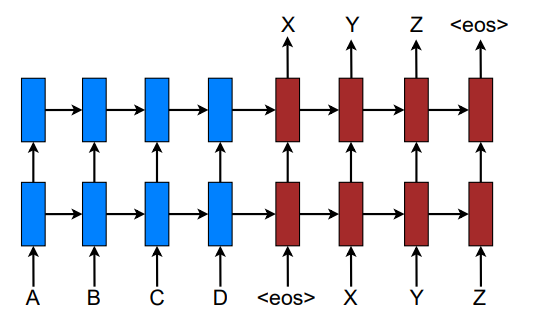

Image Source: [Luong et al. 2015](https://arxiv.org/pdf/1508.04025.pdf)

## Encoder

In [152]:
class Encoder(nn.Module):

  def __init__(self,src_vocab_size,embed_dim,lstm_hidden_dim):
    super().__init__()
    self.embedding = nn.Embedding(src_vocab_size,embed_dim,padding_idx=1)
    self.stacked_lstm = nn.LSTM(embed_dim,lstm_hidden_dim,num_layers=2,batch_first=True)

  def forward(self,input):
    """
    INPUT:
      input: [batch_size,src_seq_length]
      hidden(implicit): [2,batch_size,lstm_hidden_dim]
      cell(implicit): [2,batch_size,lstm_hidden_dim]

    OUTPUT:
      out: [batch_size,src_seq_length,lstm_hidden_dim]
      hidden: [2,batch_size,lstm_hidden_dim]
      cell: [2,batch_size,lstm_hidden_dim]
    """
    
    ## out: [batch_size,src_seq_length,embed_dim]
    out = self.embedding(input)

    ## out: [batch_size,src_seq_length,lstm_hidden_dim]
    ## hidden: [1,batch_size,lstm_hidden_dim]
    ## cell: [1,batch_size,lstm_hidden_dim]
    out,(hidden,cell) = self.stacked_lstm(out)

    return out,hidden,cell

## Global Attention










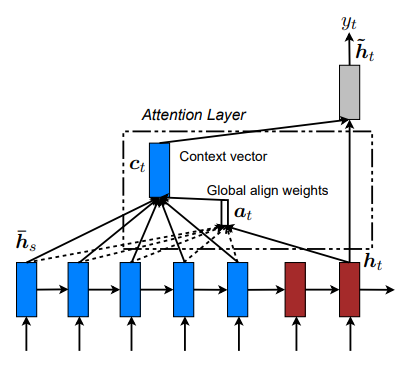

Image Source: [Luong et al. 2015](https://arxiv.org/pdf/1508.04025.pdf)


It takes as input the hidden state h<sub>t</sub>  at the top layer of a stacking LSTM. In the paper, the authors used **location-based** function to compute alignment score. It is given by,&nbsp;&nbsp;&nbsp; ***a***<sub>t</sub> = softmax(***W***<sub>a</sub>***h***<sub>t</t>)

Given the alignment vector as weights, the context
vector c<sub>t</sub> is computed as the weighted average over
**all** the source hidden states. Later, context vector is concatenated with target hidden state, which is then fed to fully-connected layer to transform it into a vector of
 size: **tgt_vocab_size**.

In [153]:
class Attention(nn.Module):

  def __init__(self,lstm_hidden_dim):   
    super().__init__()
    self.fc = nn.Linear(lstm_hidden_dim,1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self,tgt_hid,src_out):
    """
    INPUT:
      tgt_hid: [batch_size,1,lstm_hidden_dim]
      src_out: [batch_size,src_seq_length,lstm_hidden_dim]

    OUTPUT:
      align_score: [batch_size,src_seq_length,1]
    """

    src_length = src_out.shape[1]

    ## out: [batch_size,src_seq_length,lstm_hidden_dim]
    out = tgt_hid.repeat(1,src_length,1)

    ## out: [batch_size,src_seq_length,1]
    out = self.fc(out)

    return self.softmax(out)

In [154]:
class Decoder(nn.Module):

  def __init__(self,tgt_vocab_size,embed_dim,lstm_hidden_dim):
    super().__init__()
    self.attention = Attention(lstm_hidden_dim)
    self.embedding = nn.Embedding(tgt_vocab_size,embed_dim,padding_idx=1)
    self.lstm = nn.LSTM(embed_dim,lstm_hidden_dim,num_layers=2,batch_first=True)
    self.fc = nn.Linear(lstm_hidden_dim*2,tgt_vocab_size)

  def forward(self,src_out,hidden,cell,tgt_hid):
    """
    INPUT:
      src_out: [batch_size,src_seq_length,lstm_hidden_dim]
      tgt_hid: [batch_size]
      hidden: [2,batch_size,lstm_hidden_dim]
      cell: [2,batch_size,lstm_hidden_dim]

    OUTPUT:
      out: [batch_size,tgt_vocab_size]         
      hidden: [2,batch_size,lstm_hidden_dim]
      cell: [2,batch_size,lstm_hidden_dim]
    """

    src_seq_length = src_out.shape[1]

    ## out: [batch_size,1]
    out = tgt_hid.unsqueeze(1)

    ## out: [batch_size,1,embed_dim]
    out = self.embedding(out)

    ## out: [batch_size,1,lstm_hidden_dim]
    ## hidden: [2,batch_size,lstm_hidden_dim]
    ## cell: [2,batch_size,lstm_hidden_dim]
    out,(hidden,cell) = self.lstm(out)

    ## align_score: [batch_size,src_seq_length,1]
    align_score = self.attention(out,src_out).permute(0,2,1)   

    ## score: [batch_size,src_seq_length,1]
    score = align_score/align_score.sum(1).unsqueeze(1)

    ## context: [batch_size,1,lstm_hidden_dim]
    context = torch.bmm(score,src_out)

    ## out: [batch_size,1,2*lstm_hidden_dim]
    out = torch.concat([out,context],dim=2).squeeze(1)

    ## out: [batch_size,tgt_vocab_size]
    out = self.fc(out)
    
    return out, hidden, cell

In [155]:
class Finalized_Model(nn.Module):

  def __init__(self,encoder,decoder,tgt_vocab_size):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.tgt_vocab_size = tgt_vocab_size

  def forward(self,src,tgt,teacher_force_ratio=0.6):
    """
    INPUT:
      src: [batch_size,src_seq_length]
      tgt: [batch_size,tgt_seq_length]

    OUTPUT:
      output: [batch_size,tgt_seq_length,TGT_VOCAB_SIZE]
    """
    batch_size = tgt.shape[0]
    tgt_len = tgt.shape[1]

    output = torch.zeros(batch_size,tgt_len,self.tgt_vocab_size)

    # src_out: [batch_size,src_seq_length,lstm_hidden_dim]
    # hidden: [2,batch_size,lstm_hidden_dim]
    # cell: [2,batch_size,lstm_hidden_dim]
    src_out,hidden,cell = self.encoder(src)  

    ## x: [batch_size]
    x = tgt[:,0]

    for t in range(tgt_len):

      # out: [batch_size,tgt_vocab_size]
      # hidden: [2,batch_size,lstm_hidden_dim]
      # cell: [2,batch_size,lstm_hidden_dim]
      out,hidden,cell = self.decoder(src_out,hidden,cell,x)

      output[:,t,:] = out
      best_guess = torch.argmax(out,dim=1)
      x = tgt[:,t] if random.random() < teacher_force_ratio else best_guess 

    return output

## Model Initialization

In [156]:
SRC_VOCAB_SIZE = len(EN_VOCAB)
TGT_VOCAB_SIZE = len(HI_VOCAB)
EMBED_DIM = 512
LSTM_HIDDEN_DIM = 1024

In [157]:
ENCODER = Encoder(SRC_VOCAB_SIZE,EMBED_DIM,LSTM_HIDDEN_DIM)
DECODER = Decoder(TGT_VOCAB_SIZE,EMBED_DIM,LSTM_HIDDEN_DIM)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Finalized_Model(ENCODER,DECODER,TGT_VOCAB_SIZE).to(DEVICE)

model

Finalized_Model(
  (encoder): Encoder(
    (embedding): Embedding(2368, 512, padding_idx=1)
    (stacked_lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (fc): Linear(in_features=1024, out_features=1, bias=True)
      (softmax): Softmax(dim=1)
    )
    (embedding): Embedding(2856, 512, padding_idx=1)
    (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
    (fc): Linear(in_features=2048, out_features=2856, bias=True)
  )
)

In [158]:
def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

print("Number of trainable params in Encoder: {:,}".format(count_parameters(ENCODER)))
print("Number of trainable params in Decoder: {:,}".format(count_parameters(DECODER)))
print("Number of trainable params in seq2seq: {:,}".format(count_parameters(model)))

Number of trainable params in Encoder: 15,908,864
Number of trainable params in Decoder: 22,011,689
Number of trainable params in seq2seq: 37,920,553


## Model Training

In [159]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [160]:
def train(data_iter):
  model.train()
  epoch_loss = 0.0

  ## src: [batch_size,src_seq_length]
  ## tgt: [batch_size,tgt_seq_length]
  for src,tgt in data_iter:
    optimizer.zero_grad()

    ## pred: [batch_size,tgt_seq_length,TGT_VOCAB_SIZE]
    pred = model(src,tgt[:,:-1])

    ## pred: [batch_size*tgt_seq_length,TGT_VOCAB_SIZE]
    pred = pred.reshape(-1,TGT_VOCAB_SIZE).to(DEVICE)

    ## tgt_label: [batch_size*tgt_seq_length]
    tgt_label = tgt[:,1:].reshape(-1)

    ## loss: [batch_size*tgt_seq_length]
    loss = loss_fn(pred,tgt_label)

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  return epoch_loss/len(data_iter)

In [161]:
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
  if epoch%5 == 0:
    loss = train(TRAIN_DL)
    print("EPOCH: {} --------> LOSS: {: .4f}".format(epoch,loss))

EPOCH: 0 --------> LOSS:  8.4545
EPOCH: 5 --------> LOSS:  3.2386
EPOCH: 10 --------> LOSS:  2.9836
EPOCH: 15 --------> LOSS:  2.8145
EPOCH: 20 --------> LOSS:  2.6896
EPOCH: 25 --------> LOSS:  2.5694
EPOCH: 30 --------> LOSS:  2.3858
EPOCH: 35 --------> LOSS:  2.2190
EPOCH: 40 --------> LOSS:  2.1577
EPOCH: 45 --------> LOSS:  2.0055


## Test Translation

In [162]:
def translate(src):
  model.eval()
  src_tokenized = torch.tensor(en_pipeline(src),device=DEVICE).unsqueeze(0)

  seed = ["<bos>"]
  tgt_tokenized = HI_VOCAB(seed)
  src_out, hidden, cell = ENCODER(src_tokenized)

  with torch.no_grad():
      while tgt_tokenized[-1] != 3 and len(tgt_tokenized) < 10:     
        input = torch.tensor(tgt_tokenized[-1],device=DEVICE).unsqueeze(0)   
        pred,hidden,cell = DECODER(src_out,hidden,cell,input)
        probs = torch.softmax(pred[0,:],dim=0)      
        prediction = torch.multinomial(probs,num_samples=1).item()

        if prediction in [0,1]:
          continue
        tgt_tokenized.append(prediction)

  itos = HI_VOCAB.get_itos()
  tokens = [itos[i] for i in tgt_tokenized]
  return tokens

This is one of the best translations the model can produce. Where did things go wrong? 


*   Location-based alignment scores appear to perform poorly when compared to alignment functions that take into account both the source and target hidden states. 
*   The dataset comprised of only 2868 training examples. Nearly half of the English and Hindi tokens appeared only once in the entire dataset, making it hard to identify any pattern



In [224]:
translate("What time is it?")

['<bos>', 'अभी', 'बजे', '<eos>']

In [239]:
translate("Do you still go to school?")

['<bos>', 'आप', 'भेज', 'है', '<eos>']

In [201]:
translate("Can I help you?")

['<bos>', 'मैं', 'सहायता', 'हो', '<eos>']